<a href="https://colab.research.google.com/github/sergienko4/deep-learing/blob/main/ex10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Learning: Ex.10 - RNN

Submitted by: [... **your name and ID** ...]


In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Input
from tensorflow.keras.layers import SimpleRNN, LSTM # <--- recurrent layers

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
from seaborn import heatmap
import re
print(tf.__version__)

2.7.0


In [2]:
from google.colab import drive
drive.mount('/content/drive')
path='/content/drive/MyDrive/ex10/war_and_peace.txt'

Mounted at /content/drive


***
### 1. Preprocess the text corpus

(if you are using google colab, remember to upload the corpus file first..)

In [3]:
# f = open('war_and_peace.txt','r') # open the corpus file
f = open(path,'r') 
text = f.read().lower()  # read file and convert to lower-case letters
data = text.replace('\n',' ')

data = re.sub(r'[^a-zA-Z0-9 ]',r'',data)

print('len(text) = ',len(text))

print(data[:400]) # print the first 400 characters..

len(text) =  3196213
well prince so genoa and lucca are now just family estates of the buonapartes but i warn you if you dont tell me that this means war if you still try to defend the infamies and horrors perpetrated by that antichristi really believe he is antichristi will have nothing more to do with you and you are no longer my friend no longer my faithful slave as you call yourself but how do you do i see i have 


- generate training sequences of `T=20` characters, by sampling the text corpus with a stride of 5 characters (i.e., each sequences starts 5 chars after the begining of the last sequences).

- generate a matching list, holding the `next_char` for each of your sequences.

- how many sequences did you extract in total? `N = ?`

- convert the sequences into a 1-hot representation, suitable for our model trainig:

`X.shape = (N, T, len(chars))`

`Y.shape = (N, len(chars))`

In [4]:
chars = sorted(list(set(data)))
data_size, vocab_size = len(data), len(chars)
print('There are %d total characters and %d unique characters in your data.' % (data_size, vocab_size))
print('chars = ',chars)

There are 3083435 total characters and 37 unique characters in your data.
chars =  [' ', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


In [5]:
char_to_ix = { ch:i for i,ch in enumerate(chars) }
ix_to_char = { i:ch for i,ch in enumerate(chars) }

In [6]:
T = 20  # extract training sequences of length T
stride = 5

sequences = []  # This holds our extracted sequences
next_chars = []  # This holds the targets (the follow-up character)

for i in range(0, len(data) - T, stride):
    sequences.append(data[i: i + T])
    next_chars.append(data[i + T])

In [7]:
X = np.zeros((len(sequences), T, len(chars)), dtype='bool')
Y = np.zeros((len(sequences), len(chars)), dtype='bool')

for i, seq in enumerate(sequences):
    for t, char in enumerate(seq):
        X[i, t, char_to_ix[char]] = 1
    Y[i, char_to_ix[next_chars[i]]] = 1
    
print('X.shape = (#examples, T, input-dim) =', X.shape)
print('Y.shape = (#examples, output-dim) =', Y.shape)

X.shape = (#examples, T, input-dim) = (616683, 20, 37)
Y.shape = (#examples, output-dim) = (616683, 37)


***
### 2. LTSM Model

- Build an `LTSM` model with 128 (hidden)-units that accepts the input sequences. Add a `Dense` layer on top of it, with `len(chars)` softmax units.

- Train the model for only 1 epoch (use: `RMSprop` and batch size of 128).



In [8]:
model = Sequential(name='LSTM_128')
model.add(Input(shape=(T, len(chars))))  # (12,27)
model.add(LSTM(128)) # 128 internal state units
model.add(Dense(len(chars), activation="softmax"))
model.summary()

Model: "LSTM_128"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               84992     
                                                                 
 dense (Dense)               (None, 37)                4773      
                                                                 
Total params: 89,765
Trainable params: 89,765
Non-trainable params: 0
_________________________________________________________________


In [9]:
model.compile(loss='categorical_crossentropy', optimizer='rmsprop')

history = model.fit(X, Y, epochs=1, batch_size=128)

4818/4818 [==============================] - 22s 4ms/step - loss: 2.0316


### 3. Model predictions


- use the senternce `the meaning of life ` as an input to the model (convert it to 1-hot first..),

- plot the model's output as a probability distribution over the list of chars.

- sample a single char from that distribution, and add it to the generated sentence.

- update the 1-hot buffer, and continue the process for 99 more letters (using a loop).

- print the resulting sentence.

In [10]:
input = 'the meaning of life'

In [11]:
input_one_hot = np.zeros((len(input), T, len(chars)), dtype='bool')

In [12]:
input_one_hot.shape

(19, 20, 37)

In [13]:
y_hat = model.predict(input_one_hot)

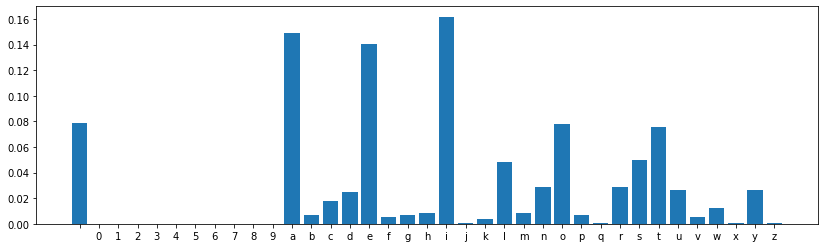

In [14]:
plt.figure(figsize=(14,4))
plt.bar(range(len(chars)), y_hat[0])
plt.xticks(range(len(chars)), labels=chars)
plt.show()

In [15]:
input_buffer = input_one_hot[0]
generated_text = input

yy = []
for i in range(100):
    yhat = model.predict(input_buffer[None,:])
    # sample the next character:
    # ix = np.argmax(yhat)
    ix = np.random.choice(range(len(chars)), p=yhat[0])
    ch = ix_to_char[ix]
    generated_text += ch
    # update the input buffer:
    input_buffer = np.r_[input_buffer[1:,:], np.zeros((1,len(chars)))]
    input_buffer[-1,ix] = 1
    yy.append(yhat)
print(generated_text)

the meaning of lifes whies he pessed fortentan exclingitlant the sall om to the comane stound them turet ta ht and all 


***
### 3. Fit your model

- Fit your model a bit more (try 10-20 epochs), and regenerate a new `N=100` sentence sample. Does it get any better?

- If you wish, you can try to train the model further, or you can try using a different corpus (dataset) for the training (you can even try a text in hebrew). Be creative ;)

In [16]:
history = model.fit(X, Y, epochs=20, batch_size=128)

Epoch 1/20
4818/4818 [==============================] - 18s 4ms/step - loss: 1.6541
Epoch 2/20
4818/4818 [==============================] - 18s 4ms/step - loss: 1.5229
Epoch 3/20
4818/4818 [==============================] - 20s 4ms/step - loss: 1.4498
Epoch 4/20
4818/4818 [==============================] - 19s 4ms/step - loss: 1.4016
Epoch 5/20
4818/4818 [==============================] - 18s 4ms/step - loss: 1.3670
Epoch 6/20
4818/4818 [==============================] - 18s 4ms/step - loss: 1.3401
Epoch 7/20
4818/4818 [==============================] - 18s 4ms/step - loss: 1.3190
Epoch 8/20
4818/4818 [==============================] - 18s 4ms/step - loss: 1.3016
Epoch 9/20
4818/4818 [==============================] - 18s 4ms/step - loss: 1.2872
Epoch 10/20
4818/4818 [==============================] - 18s 4ms/step - loss: 1.2751
Epoch 11/20
4818/4818 [==============================] - 18s 4ms/step - loss: 1.2642
Epoch 12/20
4818/4818 [==============================] - 18s 4ms/step - lo

In [17]:
input_buffer = input_one_hot[0]
generated_text = input

yy = []
for i in range(100):
    yhat = model.predict(input_buffer[None,:])
    # sample the next character:
    # ix = np.argmax(yhat)
    ix = np.random.choice(range(len(chars)), p=yhat[0])
    ch = ix_to_char[ix]
    generated_text += ch
    # update the input buffer:
    input_buffer = np.r_[input_buffer[1:,:], np.zeros((1,len(chars)))]
    input_buffer[-1,ix] = 1
    yy.append(yhat)
print(generated_text)

the meaning of lifeqqxjjjykxqxxxxitifless of god was most day coming rose and activation without eath toward beside on 


In [19]:
#---------------------------------------------------freestyle---------------------------------------------------

In [22]:
model_freestyle = Sequential(name='freestyle')
model_freestyle.add(LSTM(
        256,
        input_shape=(X.shape[1], X.shape[2]),
        return_sequences=True
    ))
model_freestyle.add(Dropout(0.3))
model_freestyle.add(LSTM(512, return_sequences=True))
model_freestyle.add(Dropout(0.3))
model_freestyle.add(LSTM(256))
model_freestyle.add(Dense(256))
model_freestyle.add(Dropout(0.3))
model_freestyle.add(Dense(vocab_size))
model_freestyle.add(Activation('softmax'))
model_freestyle.compile(loss='categorical_crossentropy', optimizer='rmsprop')
model_freestyle.summary()


Model: "freestyle"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 20, 256)           301056    
                                                                 
 dropout_3 (Dropout)         (None, 20, 256)           0         
                                                                 
 lstm_5 (LSTM)               (None, 20, 512)           1574912   
                                                                 
 dropout_4 (Dropout)         (None, 20, 512)           0         
                                                                 
 lstm_6 (LSTM)               (None, 256)               787456    
                                                                 
 dense_3 (Dense)             (None, 256)               65792     
                                                                 
 dropout_5 (Dropout)         (None, 256)               0 

In [23]:
history = model_freestyle.fit(X, Y, epochs=50, batch_size=70)

Epoch 1/50
8810/8810 [==============================] - 121s 13ms/step - loss: 1.8061
Epoch 2/50
8810/8810 [==============================] - 116s 13ms/step - loss: 1.4056
Epoch 3/50
8810/8810 [==============================] - 116s 13ms/step - loss: 1.3170
Epoch 4/50
8810/8810 [==============================] - 116s 13ms/step - loss: 1.2733
Epoch 5/50
8810/8810 [==============================] - 116s 13ms/step - loss: 1.2445
Epoch 6/50
8810/8810 [==============================] - 116s 13ms/step - loss: 1.2226
Epoch 7/50
8810/8810 [==============================] - 116s 13ms/step - loss: 1.2043
Epoch 8/50
8810/8810 [==============================] - 117s 13ms/step - loss: 1.1906
Epoch 9/50
8810/8810 [==============================] - 117s 13ms/step - loss: 1.1783
Epoch 10/50
8810/8810 [==============================] - 116s 13ms/step - loss: 1.1668
Epoch 11/50
8810/8810 [==============================] - 117s 13ms/step - loss: 1.1575
Epoch 12/50
8810/8810 [=============================

In [24]:
input_buffer = input_one_hot[0]
generated_text = input

yy = []
for i in range(100):
    yhat = model.predict(input_buffer[None,:])
    # sample the next character:
    # ix = np.argmax(yhat)
    ix = np.random.choice(range(len(chars)), p=yhat[0])
    ch = ix_to_char[ix]
    generated_text += ch
    # update the input buffer:
    input_buffer = np.r_[input_buffer[1:,:], np.zeros((1,len(chars)))]
    input_buffer[-1,ix] = 1
    yy.append(yhat)
print(generated_text)

the meaning of lifeqjzqqqjqqxxxxxhersy and tractle miserisary could say you are yes it you see pierre had been betting 


In [3]:
path='/content/drive/MyDrive/ex10/russian_troll_tweets_.txt'
# f = open('war_and_peace.txt','r') # open the corpus file
f = open(path,'r') 
text = f.read().lower()  # read file and convert to lower-case letters
data = text.replace('\n','.')
data = re.sub(r'[^a-zA-Z0-9 ]',r'',data)



# data = re.sub(r'[^a-zA-Z0-9 ]',r'',data)

print('len(text) = ',len(data))

print(data[:400]) # print the first 400 characters..

chars = sorted(list(set(data)))
data_size, vocab_size = len(data), len(chars)
print('There are %d total characters and %d unique characters in your data.' % (data_size, vocab_size))
print('chars = ',chars)

char_to_ix = { ch:i for i,ch in enumerate(chars) }
ix_to_char = { i:ch for i,ch in enumerate(chars) }

T = 50  # extract training sequences of length T
stride = 10

sequences = []  # This holds our extracted sequences
next_chars = []  # This holds the targets (the follow-up character)

for i in range(0, len(data) - T, stride):
    sequences.append(data[i: i + T])
    next_chars.append(data[i + T])

X = np.zeros((len(sequences), T, len(chars)), dtype='bool')
Y = np.zeros((len(sequences), len(chars)), dtype='bool')

for i, seq in enumerate(sequences):
    for t, char in enumerate(seq):
        X[i, t, char_to_ix[char]] = 1
    Y[i, char_to_ix[next_chars[i]]] = 1

print('X.shape = (#examples, T, input-dim) =', X.shape)
print('Y.shape = (#examples, output-dim) =', Y.shape)

len(text) =  694050
the question in this election who can put the plans into action that will make your life better httpstcoxreey9oicglast night donald trump said not paying taxes was smart you know what i call it unpatriotic httpstcot0xmbfj7zfcouldnt be more proud of hillaryclinton her vision and command during last nights debate showed that shes ready to be our next potusif we stand together theres nothing we cant 
There are 694050 total characters and 37 unique characters in your data.
chars =  [' ', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
X.shape = (#examples, T, input-dim) = (69400, 50, 37)
Y.shape = (#examples, output-dim) = (69400, 37)


In [4]:
model_freestyle = Sequential(name='freestyle')
model_freestyle.add(LSTM(
        256,
        input_shape=(X.shape[1], X.shape[2]),
        return_sequences=True
    ))
model_freestyle.add(Dropout(0.3))
model_freestyle.add(LSTM(512, return_sequences=True))
model_freestyle.add(Dropout(0.3))
model_freestyle.add(LSTM(256))
model_freestyle.add(Dense(256))
model_freestyle.add(Dropout(0.3))
model_freestyle.add(Dense(vocab_size))
model_freestyle.add(Activation('softmax'))
model_freestyle.compile(loss='categorical_crossentropy', optimizer='rmsprop')
model_freestyle.summary()

Model: "freestyle"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50, 256)           301056    
                                                                 
 dropout (Dropout)           (None, 50, 256)           0         
                                                                 
 lstm_1 (LSTM)               (None, 50, 512)           1574912   
                                                                 
 dropout_1 (Dropout)         (None, 50, 512)           0         
                                                                 
 lstm_2 (LSTM)               (None, 256)               787456    
                                                                 
 dense (Dense)               (None, 256)               65792     
                                                                 
 dropout_2 (Dropout)         (None, 256)               0 

In [27]:
history = model_freestyle.fit(X, Y, epochs=50, batch_size=70)

Epoch 1/50
992/992 [==============================] - 31s 27ms/step - loss: 2.8952
Epoch 2/50
992/992 [==============================] - 27s 27ms/step - loss: 2.4361
Epoch 3/50
992/992 [==============================] - 27s 27ms/step - loss: 2.3597
Epoch 4/50
992/992 [==============================] - 27s 27ms/step - loss: 2.2399
Epoch 5/50
992/992 [==============================] - 27s 27ms/step - loss: 2.0040
Epoch 6/50
992/992 [==============================] - 27s 27ms/step - loss: 1.8818
Epoch 7/50
992/992 [==============================] - 27s 27ms/step - loss: 1.7957
Epoch 8/50
992/992 [==============================] - 26s 27ms/step - loss: 1.7190
Epoch 9/50
992/992 [==============================] - 26s 27ms/step - loss: 1.6539
Epoch 10/50
992/992 [==============================] - 27s 27ms/step - loss: 1.5918
Epoch 11/50
992/992 [==============================] - 27s 27ms/step - loss: 1.5343
Epoch 12/50
992/992 [==============================] - 27s 27ms/step - loss: 1.4804
E

In [28]:
input = 'the meaning of life'
input_one_hot = np.zeros((len(input), T, len(chars)), dtype='bool')

In [29]:
input_buffer = input_one_hot[0]
generated_text = input

yy = []
for i in range(200):
    yhat = model_freestyle.predict(input_buffer[None,:])
    # sample the next character:
    # ix = np.argmax(yhat)
    ix = np.random.choice(range(len(chars)), p=yhat[0])
    ch = ix_to_char[ix]
    generated_text += ch
    # update the input buffer:
    input_buffer = np.r_[input_buffer[1:,:], np.zeros((1,len(chars)))]
    input_buffer[-1,ix] = 1
    yy.append(yhat)
print(generated_text)

the meaning of lifee en 10 billion is child on fornews of no all of the factowfornthillary clinton lillion the onested can everyone can health care aed opportunity to donald trump work realdonaldtrump neid oornews who l


In [10]:
model_freestyle = Sequential(name='freestyle')
model_freestyle.add(Input(shape=(T, len(chars))))  # (12,27)
model_freestyle.add(LSTM(128)) # 128 internal state units
model_freestyle.add(Dense(len(chars), activation="softmax"))
model_freestyle.summary()
model_freestyle.compile(loss='categorical_crossentropy', optimizer='rmsprop')

Model: "freestyle"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_5 (LSTM)               (None, 128)               84992     
                                                                 
 dense_4 (Dense)             (None, 37)                4773      
                                                                 
Total params: 89,765
Trainable params: 89,765
Non-trainable params: 0
_________________________________________________________________


In [11]:
history = model_freestyle.fit(X, Y, epochs=60, batch_size=50)
input = 'the meaning of life'
input_one_hot = np.zeros((len(input), T, len(chars)), dtype='bool')

Epoch 1/60
1388/1388 [==============================] - 9s 5ms/step - loss: 2.6395
Epoch 2/60
1388/1388 [==============================] - 7s 5ms/step - loss: 2.2856
Epoch 3/60
1388/1388 [==============================] - 7s 5ms/step - loss: 2.1369
Epoch 4/60
1388/1388 [==============================] - 7s 5ms/step - loss: 2.0294
Epoch 5/60
1388/1388 [==============================] - 7s 5ms/step - loss: 1.9476
Epoch 6/60
1388/1388 [==============================] - 7s 5ms/step - loss: 1.8814
Epoch 7/60
1388/1388 [==============================] - 7s 5ms/step - loss: 1.8248
Epoch 8/60
1388/1388 [==============================] - 7s 5ms/step - loss: 1.7735
Epoch 9/60
1388/1388 [==============================] - 7s 5ms/step - loss: 1.7281
Epoch 10/60
1388/1388 [==============================] - 7s 5ms/step - loss: 1.6864
Epoch 11/60
1388/1388 [==============================] - 7s 5ms/step - loss: 1.6469
Epoch 12/60
1388/1388 [==============================] - 7s 5ms/step - loss: 1.6087
E

In [12]:
input_buffer = input_one_hot[0]
generated_text = input

yy = []
for i in range(200):
    yhat = model_freestyle.predict(input_buffer[None,:])
    # sample the next character:
    # ix = np.argmax(yhat)
    ix = np.random.choice(range(len(chars)), p=yhat[0])
    ch = ix_to_char[ix]
    generated_text += ch
    # update the input buffer:
    input_buffer = np.r_[input_buffer[1:,:], np.zeros((1,len(chars)))]
    input_buffer[-1,ix] = 1
    yy.append(yhat)
print(generated_text)

the meaning of lifeket no the mettrubp beckity of everyone clunte we will make america great againnettlenk agreitwhip  mastreys to be about the first all saxelve in therellang liy to have they armom at we repted a ve go


***
## Good Luck!